In [1]:
from hilde.parsers import read_aims, read_aims_output
from hilde.helpers.supercell import find_cubic_cell
from hilde.helpers.paths import cwd
from hilde.helpers.k_grid import d2k
from hilde.helpers.geometry import get_cubicness
from hilde.helpers.maths import clean_matrix
from hilde.phonopy import phono as ph
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ase.calculators.aims import Aims
from ase.calculators.socketio import SocketIOCalculator
from ase.dft.kpoints import get_cellinfo, special_paths, bandpath
from ase.build.supercells import make_supercell
from time import time
%matplotlib inline

In [2]:
atoms = read_aims('gan.in')
vol = atoms.get_volume()
atoms

Atoms(symbols='Ga2N2', pbc=True, cell=[[3.19141392, 0.0, 0.0], [-1.59570696, 2.76384552871, 0.0], [0.0, 0.0, 5.2020046896]])

In [3]:
command = 'orterun -n 4 aims.x'
species_dir = '/home/knoop/FHIaims/aimsfiles/species_defaults/light'
port = 31415

k_grid = d2k(atoms, 1)

aims_settings = {
    'command': command,
    'species_dir': species_dir,
    'output_level': 'MD_light',
    'relativistic': 'atomic_zora scalar',
    'xc': 'pw-lda',
    'k_grid': k_grid,
    'sc_accuracy_rho': 1e-6,
    'compute_forces': True
}

print(k_grid)

[4, 4, 2]


### Relaxation

In [4]:
relax_settings = {
    'relax_geometry': 'lattice_trm 1e-3',
    'relax_unit_cell': 'full',
    'sc_accuracy_forces': 1e-4,
    'use_symmetric_forces': True
}
relax_folder = Path().cwd() / 'relax'
aims = Aims(**{**aims_settings, **relax_settings})

In [5]:
# calc = SocketIOCalculator(aims, log=relax_log.open('w'), port=port)
try:
    ratoms = read_aims(relax_folder / 'geometry.in.next_step')
except FileNotFoundError:
    relax_folder.mkdir(exist_ok=True)
    atoms.calc = aims
    with cwd(relax_folder):
        atoms.calc.calculate(atoms)
    ratoms = read_aims(relax_folder / 'geometry.in.next_step')

In [6]:
n_target = 10
target_size = n_target / len(atoms)

In [7]:
smatrix = find_cubic_cell(cell=ratoms.cell, target_size=target_size)
smatrix

array([[ 1, -1,  0],
       [ 1,  2,  0],
       [ 0,  0,  1]], dtype=int32)

In [8]:
clean_matrix(make_supercell(ratoms, smatrix).cell, eps=1e-8)

array([[ 4.74882718, -2.74173665,  0.        ],
       [ 0.        ,  5.4834733 ,  0.        ],
       [ 0.        ,  0.        ,  5.1572124 ]])

In [9]:
# smatrix = np.eye(3, dtype=int)
phonon, sc, scs = ph.preprocess(ratoms, smatrix.T)

In [10]:
clean_matrix(sc.cell, eps=1e-8)

array([[ 4.74882718, -2.74173665,  0.        ],
       [ 0.        ,  5.4834733 ,  0.        ],
       [ 0.        ,  0.        ,  5.1572124 ]])

In [11]:
len(scs)

4

In [12]:
workdir = Path('./GaN_{}{}{}_{}{}{}_{}{}{}_{:.3f}'.format(*smatrix.flatten(), vol)).absolute()
workdir.mkdir(exist_ok=True)

In [13]:
k_grid = d2k(sc, 1)
print(k_grid)

[2, 2, 2]


## the traditional way

In [14]:
sc_settings = {
    'k_grid': k_grid
}
aims = Aims(**{**aims_settings, **sc_settings})

force_sets = []

stime = time()

for ii, cell in enumerate(scs):
    folder_with_disp = workdir / f'disp-{ii:03d}'
    folder_with_disp.mkdir(parents=True, exist_ok=True)
    try:
        force = read_aims_output(folder_with_disp / 'aims.out')[0].get_forces()
    except (FileNotFoundError, IndexError):
        cell.calc = aims
        with cwd(folder_with_disp):
            try:
                cell.calc.calculate(cell)
            except Error as inst:
                print(inst)
        force = read_aims_output(folder_with_disp / 'aims.out')[0].get_forces()
    force_sets.append(force)

timing_file_io = time()-stime
print(f'.. done in {timing_file_io:.3f}s')

.. done in 393.957s


In [15]:
len(force_sets)

4

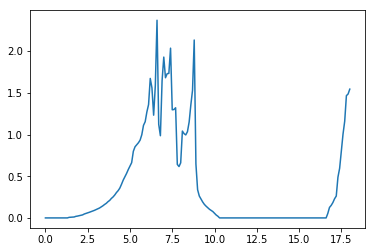

In [16]:
dos = ph.get_dos(phonon, force_sets=force_sets)
plt.plot(dos[0], dos[1])

In [17]:
cellinfo = get_cellinfo(ratoms.cell)
path = special_paths[cellinfo.lattice]
bandpath = bandpath(path, atoms.cell)

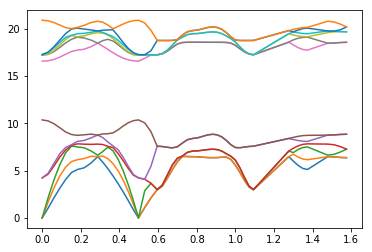

In [18]:
qp, dd, fr, ev = ph.get_bandstructure(phonon, bandpath)
_ = plt.plot(dd[0], fr[0])

### SocketIO

In [19]:
from ase.io import Trajectory
from contextlib import ExitStack

In [20]:
# reset the phonon object
phonon, sc, scs = ph.preprocess(ratoms, smatrix.T)

In [21]:
def compute_phonons_socketio(scs, calculator, port, tmp_dir, traj_file, phonopy_log):
    force_sets = []
    with ExitStack() as stack, cwd(tmp_dir):
        calc = stack.enter_context(SocketIOCalculator(aims, log=phonopy_log.open('w'), port=port))
        traj = stack.enter_context(Trajectory(str(traj_file), mode='a'))
        atoms = sc.copy()
        atoms.calc = calc
        for ii, cell in enumerate(scs):
            try:
                atoms.positions = cell.positions
                atoms.calc.calculate(atoms, system_changes=['positions'])
                force_sets.append(atoms.get_forces())
                traj.write(atoms)
            except Error as inst:
                print(inst)
    return force_sets

In [23]:
socketio_settings = {
    'use_pimd_wrapper': ('localhost', port),
#    'sc_accuracy_forces': 1e-4,
    'k_grid': k_grid
}
aims = Aims(**{**aims_settings, **socketio_settings})
phonopy_log = workdir/'phonopy.log'
traj_file = workdir / 'phonopy.traj'
tmp_dir=workdir / 'socketio'

if traj_file.exists():
    traj = Trajectory(str(traj_file), 'r')
    force_sets = [a.get_forces() for a in traj]
else:
    stime = time()
    tmp_dir.mkdir(exist_ok=True)
    force_sets = compute_phonons_socketio(scs=scs,
                                          calculator=aims,
                                          port=port,
                                          tmp_dir=tmp_dir,
                                          traj_file=traj_file,
                                          phonopy_log=phonopy_log)
    timing_socket_io = time()-stime
    print(f'.. done in {timing_socket_io:.2f}s')
    print(f'.. Speedup: {(1 - timing_socket_io / timing_file_io)*100:.2f}%')

.. done in 319.804s
.. Speedup: 18.823%


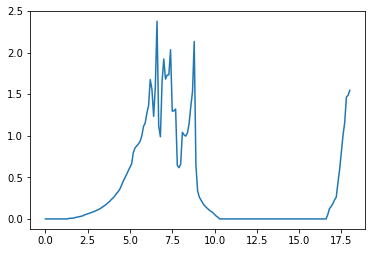

In [24]:
dos = ph.get_dos(phonon, force_sets=force_sets)
plt.plot(dos[0], dos[1])

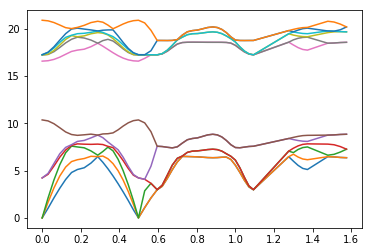

In [25]:
qp, dd, fr, ev = ph.get_bandstructure(phonon, bandpath)
_ = plt.plot(dd[0], fr[0])